# Machine Learning  Project - Using Clustering on the Eucalyptus Dataset


## Introduction

 The goal of this project is to apply two algorithms that were taught to a given dataset. I will be using the eucalyptus data set for this project. The two algorithms I will be using is K-Means and AgglomerativeClustering. This is  a publicly avaible dataset which is availible  from many sources including the OpenML website. The author of the data is Bruce Bulloch.  The objective of the study conducted was to study euclayptus seedlots and determine which species are best for soil conservation. 

In [237]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from __future__ import print_function
import os
import seaborn as sns
data_path = ['data']
filepath = os.sep.join(data_path + ['dataset_194_eucalyptus.csv'])
data = pd.read_csv(filepath)

## Motivation

 It would be beneficial to apply machine learning concepts to this dataset as it would be helpful to find  a way to determine the usefulness of soil in the conservation of Eucalyptus plants. Through building a model ,said model can be used to classify certain seedlots. This is beneficial to the overall sustainibiliy of the world as Eucalyptus  encompasses over seven hundred species of flowering plants which make up essential components of their respective ecosystems

### Dataset Information

The dataset exists in a CSV file format. It includes several diffrent attributes such as the amount of Rainfall that the seedplot experienced. All of these features map to the Utility target label which represents whether  a particular seedplot is good or not. It is important to probe the data and check the properities of it before building a model. We can start by taking a peak at the first five data entries as well as the amount of rows and columns.

In [238]:
(rows,cols) = data.shape
print("There are {rows} rows and {cols} columns".format(rows=rows,cols=cols))
data.head()

There are 736 rows and 20 columns


,Abbrev,Rep,Locality,Map_Ref,Latitude,Altitude,Rainfall,Frosts,Year,Sp,PMCno,DBH,Ht,Surv,Vig,Ins_res,Stem_Fm,Crown_Fm,Brnch_Fm,Utility
0,Cra,1,Central_Hawkes_Bay,N135_382/137,39__38,100,850,-2,1980,co,1520,18.45,9.96,40,4,3,3.5,4,3.5,good
1,Cra,1,Central_Hawkes_Bay,N135_382/137,39__38,100,850,-2,1980,fr,1487,13.15,9.65,90,4.5,4,3.5,3.5,3,best
2,Cra,1,Central_Hawkes_Bay,N135_382/137,39__38,100,850,-2,1980,ma,1362,10.32,6.5,50,2.3,2.5,3,3.5,3,low
3,Cra,1,Central_Hawkes_Bay,N135_382/137,39__38,100,850,-2,1980,nd,1596,14.8,9.48,70,3.7,3,3.3,4,3.5,good
4,Cra,1,Central_Hawkes_Bay,N135_382/137,39__38,100,850,-2,1980,ni,2088,14.5,10.78,90,4,2.7,3.3,3,3,good


# 
Because Sci-kit learn works best with numerical data it is critical that we look at the data types within the data to ensure that there are no objects that will be hard to process. In the case of this dataset we can see that there are 15 object data types and just 5 integers. This signifies that some sort of encoding might be needed. Although we have not accounted for missing or "None" values.

In [239]:
types = data.dtypes
type_count = types.value_counts()
print(type_count)
#print("There are {numObjects} Object Values and  {numInts} Integers".format(numObjects=type_count.loc['object'],numInts=type_count.loc['int64']))
types

object    15
int64      5
dtype: int64


Abbrev      object
Rep          int64
Locality    object
Map_Ref     object
Latitude    object
Altitude     int64
Rainfall     int64
Frosts       int64
Year         int64
Sp          object
PMCno       object
DBH         object
Ht          object
Surv        object
Vig         object
Ins_res     object
Stem_Fm     object
Crown_Fm    object
Brnch_Fm    object
Utility     object
dtype: object

## Feature Processing and Feature Engineering

# 
A fundamental challenge of machine learning is choosing which data would be important to the model or not.  Taking a look at the data it seems that site Abbreviation ,Site Rep  and Map Reference can be dropped from the dataset. Though these maybe slightly important to the Utility of the seedplot they seem more like housekpeeing columns than significant features. Though a correlation matrix has not been calculated yet it can be extected that Latitutude will be correlated to locality and thus can be dropped. Let us also seperate the numerical columns

In [218]:
data = data.drop(["Abbrev","Rep","Map_Ref","Latitude"],axis=1,)
numericalColumns = [x for x in data.columns if x not in ["Locality","Sp","Utility"]]
floatColumns = [x for x in numericalColumns if x not in ["Altitude","Rainfall","Frosts","Year"]]
intColumns = ["Altitude","Rainfall","Frosts","Year"]

# 
Now we have to remove the missing data and convert the numerical data to floats.Given that we`ll be using clustering algorithms, which is unsupervised learning, we can also drop the target label. Furthermore we can cast all float columns to float to ensure they are classified correctly.

In [219]:
chosenColumns = [x for x in data.columns if x != "Utility"]
data = data.replace(to_replace="?",value=pd.NaT)
data = data.dropna()
targetColumn = data["Utility"]
data = data[chosenColumns]
data[floatColumns] = data[floatColumns].astype(float)
data.dtypes

Locality     object
Altitude      int64
Rainfall      int64
Frosts        int64
Year          int64
Sp           object
PMCno       float64
DBH         float64
Ht          float64
Surv        float64
Vig         float64
Ins_res     float64
Stem_Fm     float64
Crown_Fm    float64
Brnch_Fm    float64
dtype: object

# 
Now we only have two String columns left.We would  need to turn these data fields into numerical ones that would be easier to work with. This can easily be done with One hot encoding. This removes the column in question and creates new columns with either 1 or 0 as a value for each option. While we are at it we could take a peak at the correlation of the data.

In [220]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
data_ohc = data.copy()
le = LabelEncoder()
ohc = OneHotEncoder()
for col in ["Sp","Locality"]:
    dat = le.fit_transform(data_ohc[col]).astype(np.int)
    # Remove the original column from the dataframe
    data_ohc = data_ohc.drop(col,axis=1)
    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))
    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ["_".join([col,str(x)]) for x in range (n_cols)]
    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(),index=data_ohc.index,columns= col_names)
    # Append the new data to the dataframe
    data_ohc = pd.concat([data_ohc,new_df],axis=1)
data = data_ohc
corr_matrix = data[numericalColumns].corr()
for x in range(len(numericalColumns)):
    corr_matrix.iloc[x,x] = 0.0
corr_matrix.abs().idxmax()

Altitude      Frosts
Rainfall        Year
Frosts      Altitude
Year        Rainfall
PMCno           Year
DBH               Ht
Ht               Vig
Surv             Vig
Vig               Ht
Ins_res          Vig
Stem_Fm     Crown_Fm
Crown_Fm     Stem_Fm
Brnch_Fm    Crown_Fm
dtype: object

In [221]:
from sklearn.preprocessing import StandardScaler
skewed_colums = data[numericalColumns].skew().sort_values(ascending=False)
skewed_colums = skewed_colums.loc[abs(skewed_colums) > 0.75]
for col in skewed_colums.index.tolist():
    data[col] = np.log1p(data[col])
sc = StandardScaler()
data[numericalColumns] = sc.fit_transform(data[numericalColumns])
data

,Altitude,Rainfall,Frosts,Year,PMCno,DBH,Ht,Surv,Vig,Ins_res,...,Sp_21,Sp_22,Sp_23,Sp_24,Locality_0,Locality_1,Locality_2,Locality_3,Locality_4,Locality_5
0,-1.171805,-2.189706,1.422528,-1.802322,-0.841552,0.575885,0.204715,-0.638838,0.929470,0.149659,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.171805,-2.189706,1.422528,-1.802322,-0.898772,0.126291,0.131120,0.980168,1.423083,1.377972,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-1.171805,-2.189706,1.422528,-1.802322,-1.115515,-0.189061,-0.616701,-0.315037,-0.748813,-0.464498,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-1.171805,-2.189706,1.422528,-1.802322,-0.709772,0.282164,0.090761,0.332565,0.633303,0.149659,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.171805,-2.189706,1.422528,-1.802322,0.143328,0.255072,0.399386,0.980168,0.929470,-0.218835,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,0.104537,-0.154603,-0.702974,-0.804664,1.067519,-0.872388,-1.203087,-0.541697,-0.551368,-1.078654,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
731,-1.171805,1.349603,1.422528,1.190653,0.940941,1.684861,0.840956,-1.027399,1.126916,0.395321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
732,-1.171805,1.349603,1.422528,1.190653,0.947877,1.379665,0.359027,-0.865499,1.423083,1.377972,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
733,-1.171805,1.349603,1.422528,1.190653,0.975620,1.150594,0.088387,1.109688,1.521806,0.149659,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Machine Learning Model Development

Now that the data has been preprocessed, we can start to build our models. We can start with the K-means clustering algorithm. This algorithm works by grouping data into n number of clusters inside of a coordinate space. To determine the amount of clusters we can leverage the difrent amount of values in the utility column. However we will still process models for a variety of cluster numbers to see how they perform. 

In [222]:
from sklearn.cluster import KMeans
from sklearn import metrics
km_list = list()
for n in range(2,21):
    km = KMeans(n_clusters=n,random_state=42)
    km = km.fit(data)
    labels = km.labels_
    km.inertia_
    km_list.append(pd.Series({
        'num_clusters':n,
        'inertia':km.inertia_,
        'silhouette_score':metrics.silhouette_score(data,labels),
        'model':km
    }))

In [223]:
amountOfClusters = targetColumn.value_counts().size
km = km_list[4].model 

# 
We can also use the AgglomerativeClustering algorithm as  a second algorithm to compare against. The algorithm Recursively merges pair of clusters of sample data.

In [224]:
from sklearn.cluster import AgglomerativeClustering

ag = AgglomerativeClustering(n_clusters=amountOfClusters,linkage="ward",compute_full_tree=True)
ag = ag.fit(data)

## Prediction/Result
With the current models built we can start to predict some results

In [225]:
data['kmeans']=km.predict(data).astype('int32')
data['agglomerative']= ag.fit_predict(data).astype('int32')
results = pd.concat([data[['kmeans','agglomerative']],targetColumn],axis=1)
results

,kmeans,agglomerative,Utility
0,1,4,good
1,1,4,best
2,1,4,low
3,1,4,good
4,1,4,good
...,...,...,...
661,5,0,average
731,3,1,average
732,3,1,good
733,3,1,good


## Evaluating the result/metrics (Include graphs
Now that we have the results we can see how the models perform. We will also take a peak at the target column however that wont be our chief metric as this unsupervised learning. We will use other metrics to see how the clusters perform

In [232]:
(results
 .groupby(['Utility','kmeans','agglomerative'])
 .size()
 .to_frame()
 .rename(columns={0:'number'})
)

number
Utility kmeans agglomerative        
average 0      3                  37
        1      4                  11
        2      2                  30
        3      1                  24
        4      0                  12
               2                   1
        5      0                  13
best    0      3                  39
        1      4                  29
        2      2                   8
        3      1                  21
        4      0                   1
good    0      3                  56
               4                   1
        1      4                  27
        2      2                  53
        3      1                  62
        4      0                   3
        5      0                   1
low     0      3                  12
        1      4                  17
        2      2                  10
        3      1                   4
        4      0                  16
               2                   2
        5      0                  41
none    0      3                  14
        1      4                   4
        2      2                   4
        3      1                   3
        4      0                  35
        5      0                  50

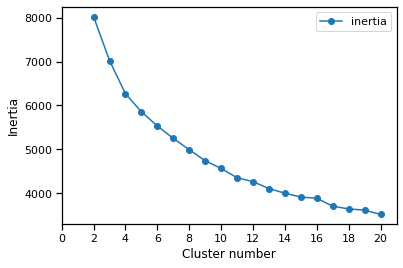

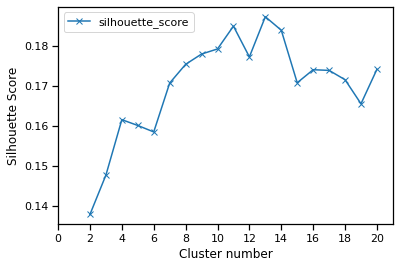

In [233]:
import matplotlib.pyplot as plt
%matplotlib inline
#ax = plt.axes();
plot_data=(
    pd.concat(km_list,axis=1)
    .T
    [['num_clusters','inertia']]
    .set_index('num_clusters')
)
ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,21,2))
ax.set_xlim(0,21)
ax.set(xlabel="Cluster number",ylabel="Inertia");
plot_data=(
    pd.concat(km_list,axis=1)
    .T
    [['num_clusters','silhouette_score']]
    .set_index('num_clusters')
)
ax = plot_data.plot(marker='x',ls='-')
ax.set_xticks(range(0,21,2))
ax.set_xlim(0,21)
ax.set(xlabel="Cluster number",ylabel="Silhouette Score");

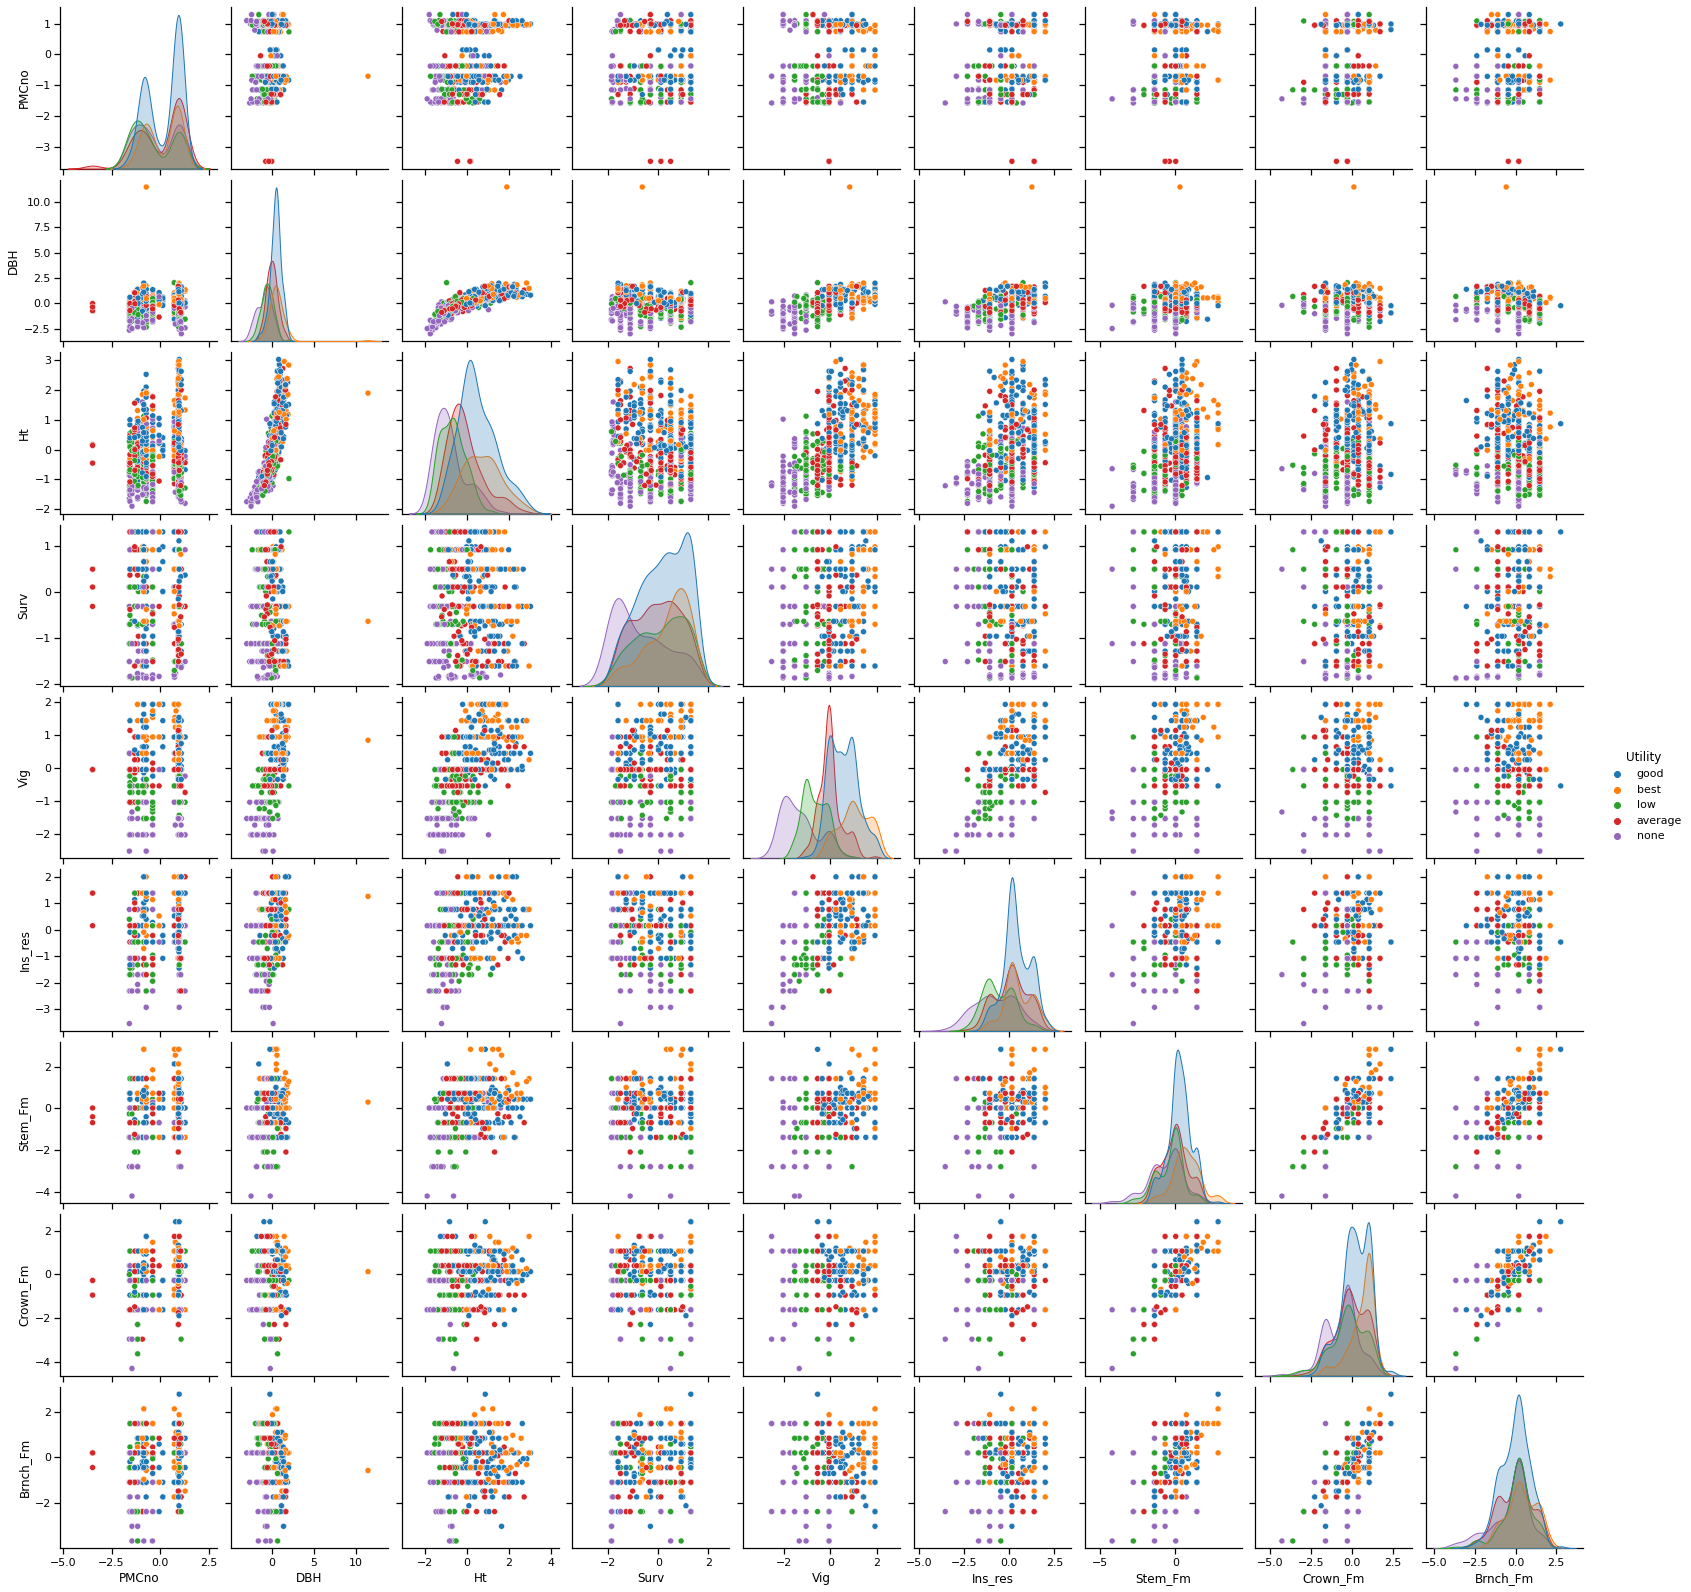

In [229]:

sns.pairplot(
pd.concat([data[floatColumns],targetColumn],axis=1),
    hue="Utility")

## Conclusion

On first expection the data set seemed to lend itself well to clustering. Though we ignored the Target column in the analysis it had five defined values which would translate to five diffrent clusters. Pairplots were constructed and the diffrent inertias were graphed as a function of the number of clusters from 2 to 20. Furthermore we checked the Silhouette Score of the diffrent models.

Given the metrics one can determine that the model does not perform very well. The Silhouette Score seems to perform best at 13 clusters in the K-Means Clustering and then drop off afterwards. 13 clusters seems to be the 'elbow' of the inertia graph as well. It may be the case that there perhaps more classes within the data than originally thought. Although it should be noted that the Silhouette Score was low for all cluster numbers tested. Classes such as "average " and "good" are given without any insight on what the classes mean. It may also be the case that the data may benefit from a diffrent algorithm. 

If given the opportunity to extend the project, I would explore The K-Medoids algorithm. Though not explored in this course, this clustering algorithm is much more robust to noise and outliers than the K-Means algorithm. Furthermore I would employ Dimensionality Reduction as well to avoid the case of too much parameters. This may be a better fit for the dataset.

## References
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
https://analyticsindiamag.com/comprehensive-guide-to-k-medoids-clustering-algorithm/
https://analyticsindiamag.com/comprehensive-guide-to-k-medoids-clustering-algorithm/